In [50]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

In [2]:
features = np.loadtxt('svm/data/features.txt', delimiter = ',')
targets = np.loadtxt('svm/data/target.txt', delimiter = ',')

In [3]:
print(features.shape)

(6414, 122)


In [4]:
print(targets.shape)

(6414,)


In [5]:
def f(w, b, features, targets, C=100):
    return 0.5 * np.sum(w ** 2) + C * np.sum(np.maximum(0, 1 - targets * (np.matmul(w, features.T)+ b)))


In [6]:
# Batch Gradient Descent (BGD)
def BGD(w, b, features, targets, C=100, lr=3e-7, ep=0.25):
    epoch = 0
    loss_history = [f(w,b,features,targets,C)]
    delta_history = [1]

    while delta_history[-1] >= ep:
        epoch +=1
        w_t = w.copy()
        b_t = b

        # update w
        for j in range(features.shape[1]):
            dw_j = w[j]
            for i in range(features.shape[0]):
                if targets[i] * (np.matmul(features[i], w) + b) < 1:
                    dw_j -= C * targets[i] * features[i,j]
            w_t[j] -= lr * dw_j

        # update b
        db = 0
        for i in range(features.shape[0]):
            if targets[i] * (np.matmul(features[i], w) + b) < 1:
                db -= C* targets[i]
        b_t -= lr * db 
    
        w = w_t.copy()
        b = b_t 

        # check convergence criterion
        loss_history.append(f(w,b,features,targets,C))
        delta_history.append(np.abs((loss_history[epoch-1] - loss_history[epoch]) * 100 / loss_history[epoch-1]))

        # print('Epoch{}: {}'.format(epoch, loss_history[-1], delta_history[-1]))

    return loss_history, delta_history




In [38]:
w = np.zeros(122)
b = 0

bgd_features = features.copy()
bgd_targets = targets.copy()
start_time = time.time()
bgd_loss, bgd_delta = BGD(w,b,bgd_features,bgd_targets,100)
bgd_time = time.time() - start_time

print('BGD: {} iterations in {:.3f} seconds'.format(len(bgd_loss)-1, bgd_time))

BGD: 57 iterations in 223.481 seconds


In [7]:
def shuffle_data(features, targets):
    p_seed = np.random.permutation(features.shape[0])
    return features[p_seed], targets[p_seed]

In [17]:
# Stochastic Gradient Descent (SGD)
def SGD(w, b, features, targets, C=100, lr=1e-4, ep=1e-3):
    epoch = 0
    i = -1
    loss_history = [f(w,b,features,targets,C)]
    delta_history = [0]

    while delta_history[-1] >= ep or epoch == 0:
        epoch +=1
        i = (i + 1) % features.shape[0]
        w_t = w.copy()
        b_t = b

        # update w
        for j in range(features.shape[1]):
            dw_j = w[j]
            if targets[i] * (np.matmul(features[i], w) + b) < 1:
                dw_j -= C * targets[i] * features[i,j]
            w_t[j] -= lr * dw_j

        # update b
        db = 0
        if targets[i] * (np.matmul(features[i], w) + b) < 1:
            db -= C* targets[i]
        b_t -= lr * db 
    
        w = w_t.copy()
        b = b_t 

        # check convergence criterion
        loss_history.append(f(w,b,features,targets,C))
        delta_history.append(0.5*delta_history[epoch-1] + 0.5 * np.abs((loss_history[epoch-1] - loss_history[epoch]) * 100 / loss_history[epoch-1]))

        # print('Epoch{}: {}\t {}'.format(epoch, loss_history[-1], delta_history[-1]))

    return loss_history, delta_history

In [37]:
w = np.zeros(122)
b = 0
sgd_features, sgd_targets = shuffle_data(features, targets)
start_time = time.time()
sgd_loss, sgd_delta = SGD(w,b,sgd_features,sgd_targets,100)
sgd_time = time.time() - start_time

print('SGD: {} iterations in {:.3f} seconds'.format(len(sgd_loss)-1, sgd_time))

SGD: 1173 iterations in 1.293 seconds


In [34]:
# Mini-Batch Gradient Descent (MGD)
def MGD(w, b, features, targets, C=100, lr=1e-5, ep=1e-2, bs=20):
    epoch = 0
    batch = -1
    loss_history = [f(w,b,features,targets,C)]
    delta_history = [0]

    while delta_history[-1] >= ep or epoch == 0:
        epoch +=1
        batch = (batch + 1) % (features.shape[0] // bs)
        w_t = w.copy()
        b_t = b

        # update w
        for j in range(features.shape[1]):
            dw_j = w[j]
            for offset in range(bs):
                i = batch * bs + offset 
                if targets[i] * (np.matmul(features[i], w) + b) < 1:
                    dw_j -= C * targets[i] * features[i,j]
            w_t[j] -= lr * dw_j

        # update b
        db = 0
        for offset in range(bs):
            i = batch * bs + offset 
            if targets[i] * (np.matmul(features[i], w) + b) < 1:
                db -= C* targets[i]
        b_t -= lr * db 
    
        w = w_t.copy()
        b = b_t 

        # check convergence criterion
        loss_history.append(f(w,b,features,targets,C))
        delta_history.append(0.5 * delta_history[epoch-1] + 0.5 * np.abs((loss_history[epoch-1] - loss_history[epoch]) * 100 / loss_history[epoch-1]))

        # print('Epoch{}: {}\t {}'.format(epoch, loss_history[-1], delta_history[-1]))

    return loss_history, delta_history

In [43]:
w = np.zeros(122)
b = 0
mgd_features, mgd_targets = shuffle_data(features, targets)
start_time = time.time()
mgd_loss, mgd_delta = MGD(w,b,mgd_features,mgd_targets,100)
mgd_time = time.time() - start_time

print('MGD: {} iterations in {:.3f} seconds'.format(len(mgd_loss)-1, mgd_time))

MGD: 716 iterations in 9.694 seconds


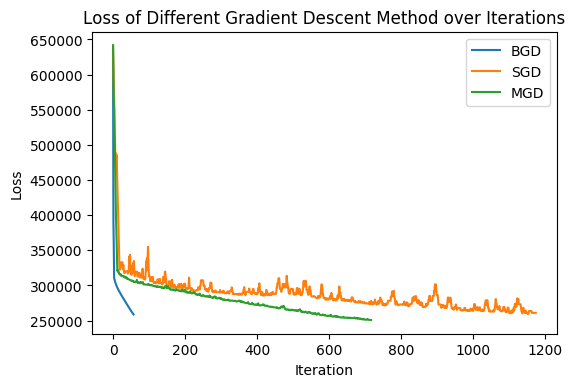

In [51]:
plt.figure()
plt.plot(np.arange(len(bgd_loss)), bgd_loss, label = 'BGD')
plt.plot(np.arange(len(sgd_loss)), sgd_loss, label = 'SGD')
plt.plot(np.arange(len(mgd_loss)), mgd_loss, label = 'MGD')
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss of Different Gradient Descent Method over Iterations')
plt.savefig('fig1.png')